** Convolutional Neural Networks (CNN)**
   *  ** Digit Number Recognizer**
# Oğuzhan Özer
<font color='red'><br> Content

* [Introduction](#1)
* [Loading the Data Set](#2)
* [Normalization, Reshape and Label Encoding](#3)
* [Train Test Split](#4)
* [Convolutional Neural Network](#5)
* [Implementing with Keras](#)
    * [Create Model](#6)
    * [Define Optimizer](#7)
    * [Compile Model](#8)
    * [Epochs and Batch Size](#9)
    * [Data Augmentation](#10)
    * [Fit the Model](#11)
    * [Evaluate the Model](#12)

<a id="1"></a> <br>
# Introduction
* We will be working on Sign language digits dataset by implementing with Keras using Artificial Neural Network in this notebook.


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


<a id="2"></a> <br>
# Loading the Data Set
* In this part we load and visualize the data.

In [2]:
train = pd.read_csv("../input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv("../input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis=1) 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

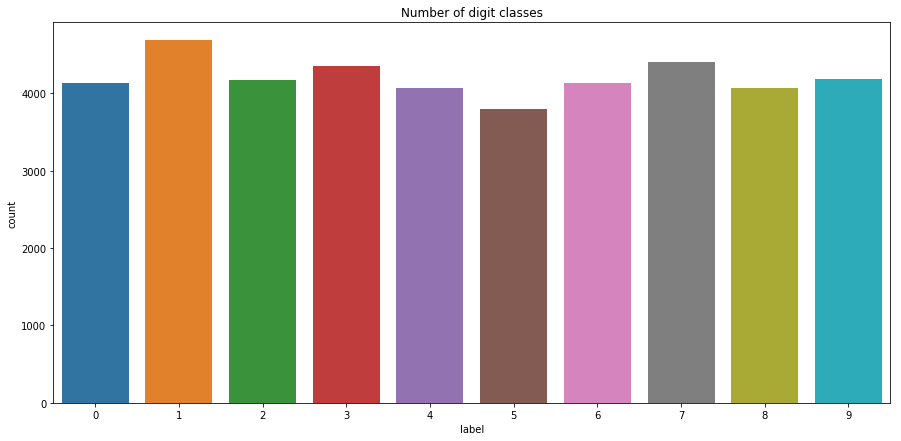

In [5]:
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train)
plt.title("Number of digit classes")
Y_train.value_counts()


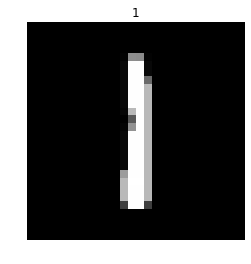

In [6]:
img = X_train.iloc[2].as_matrix()
img = img.reshape(28,28)
plt.imshow(img,cmap="gray")
plt.title(train.iloc[2,0])
plt.axis("off")
plt.show()

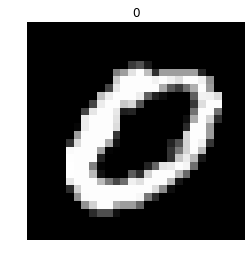

In [7]:
img = X_train.iloc[17756].as_matrix()
img = img.reshape(28,28)
plt.imshow(img,cmap="gray")
plt.title(train.iloc[17756,0])
plt.axis("off")

plt.show()


<a id="3"></a> <br>
# Normalization, Reshape and Label Encoding
* Normalization
  * We perform a grayscale normalization to reduce the effect of illumination's differences.
  * If we perform normalization, CNN works faster.
* Reshape
 * Train and test images (28 x 28)
 * We reshape all data to 28x28x1 3D matrices.
 * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel.
* Label Encoding 
 * Encode labels to one hot vectors
   * 2 => [0,0,1,0,0,0,0,0,0,0]
   * 4 => [0,0,0,0,1,0,0,0,0,0]

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [9]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [10]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)
print(Y_train.shape)

Using TensorFlow backend.


(42000, 10)


<a id="4"></a> <br>
# Train Test Split
* We split the data into train and test sets.
    * test size is 10%.
    * train size is 90%.

In [11]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


<a id="5"></a> <br>
# What is Convolution Operation?
 * We have some image and feature detector(3*3)
* Feature detector does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* Feature detector = kernel = filter
* Feauture detector detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices.
* feature map = convolved feature
* Stride = navigating in input image.
* We reduce the size of image. This is important bc code runs faster. However, we lost information.
* We create multiple feature maps bc we use multiple feature detectors(filters).
* Lets look at gimp. Edge detect: [0,10,0],[10,-4,10],[0,10,0]

<a id="6"></a> <br>
# Implementing with Keras

# Create Model
   * Dropout: Dropout is a technique where randomly selected neurons are ignored during training

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 8 , kernel_size = (5,5),activation = 'relu',padding="Same",input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16 , kernel_size = (4,4),activation = 'relu',padding="Same"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32 , kernel_size = (3,3),activation = 'relu',padding="Same"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="softmax"))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<a id="7"></a> <br>
# Define Optimizer
 * Adam optimizer: Change the learning rate

In [13]:
optimizer  = Adam(lr=0.001,beta_1=0.9,beta_2=0.999)

<a id="8"></a> <br>
# Compile Model
* categorical crossentropy
  * We make binary cross entropy at previous parts and in machine learning tutorial
  * At this time we use categorical crossentropy. That means that we have multi class.
  * ![](https://preview.ibb.co/nN3ZaU/cce.jpg)  

In [14]:
model.compile(optimizer = optimizer , loss="categorical_crossentropy",metrics=["accuracy"])

<a id="9"></a> <br>
# Epochs and Batch Size

In [15]:
epochs=100

batch_size = 250

<a id="10"></a> <br>
# Data Augmentation
   * To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
   * Alter the training data with small transformations to reproduce the variations of digit.
   * For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.
   * ![](https://preview.ibb.co/nMxXUp/augment.jpg)   

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.3, # Randomly zoom image 5%
        width_shift_range=0.3,  # randomly shift images horizontally 5%
        height_shift_range=0.3,  # randomly shift images vertically 5%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

<a id="11"></a> <br>
# Fit the model

In [17]:
#history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),epochs = epochs,validation_data=(X_val,Y_val),steps_per_epoch = X_train.shape[0])
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
151/151 [==============================] - 20s 129ms/step - loss: 2.0950 - acc: 0.2185 - val_loss: 1.2774 - val_acc: 0.6781
Epoch 2/100
151/151 [==============================] - 19s 124ms/step - loss: 1.4930 - acc: 0.4655 - val_loss: 0.5510 - val_acc: 0.8676
Epoch 3/100
151/151 [==============================] - 19s 125ms/step - loss: 1.1752 - acc: 0.6020 - val_loss: 0.3331 - val_acc: 0.9198
Epoch 4/100
151/151 [==============================] - 19s 124ms/step - loss: 1.0006 - acc: 0.6769 - val_loss: 0.2464 - val_acc: 0.9367
Epoch 5/100
151/151 [==============================] - 19s 124ms/step - loss: 0.8773 - acc: 0.7260 - val_loss: 0.2236 - val_acc: 0.9343
Epoch 6/100
151/151 [==============================] - 19s 124ms/step - loss: 0.7950 - acc: 0.7566 - val_loss: 0.1733 - val_acc: 0.9505
Epoch 7/100
151/151 [==============================] - 19s 124ms/step - loss: 0.7275 - acc: 0.7806 - val_loss: 0.1629 - val_acc: 0.9521


<a id="12"></a> <br>
# Evaluate the model
   * Test Loss visualization
   * Confusion matrix

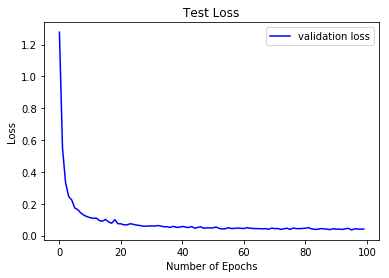

In [18]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

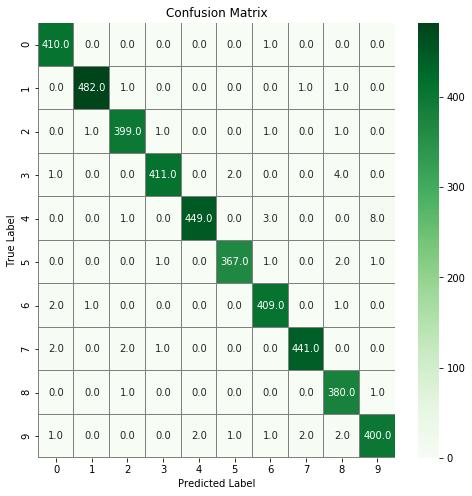

In [19]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()